# Designing and Tuning a Convolutional Neural Network (CNN)

**Project Description**: There are four parts to this project

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

In [ ]:
#Install Objax
!pip --quiet install  objax
import objax

In [ ]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0         #Looks like RGB
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

print('The length of the entire dataset is:,', len(X_data))
N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]
print('The length of X_train is:,', len(X_train))
print('The length of X_valid is:,', len(X_valid))
print('The length of X_test is:,', len(X_test))
print(len(X_train)/32)
print(len(X_train)/32*30)

The length of the entire dataset is:, 60000
The length of X_train is:, 48000
The length of X_valid is:, 6000
The length of X_test is:, 6000
1500.0
45000.0


In [ ]:
#32x32 RGB
print(len(X_train[0]))
print(len(X_train[0][0]))
print(len(X_train[0][0][0]))
print("The shape of the training data is:", np.shape(X_train))
print("The shape of the training labels is:", np.shape(Y_train))

3
32
32
The shape of the training data is: (48000, 3, 32, 32)
The shape of the training labels is: (48000,)



Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
    def __init__(self, number_of_channels = 3, number_of_classes = 10):
        self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
        self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
        self.linear = objax.nn.Linear(32, number_of_classes)

    def __call__(self, x):
        x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
        x = self.conv_2(x)

        x = x.mean((2,3)) #<--- global average pooling 
        x = self.linear(x)
        return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()
model.vars()

{'(ConvNet).conv_1(Sequential)[0](Conv2D).b': <objax.variable.TrainVar at 0x7fe7c40a55f8>,
 '(ConvNet).conv_1(Sequential)[0](Conv2D).w': <objax.variable.TrainVar at 0x7fe80ee386d8>,
 '(ConvNet).conv_2(Sequential)[0](Conv2D).b': <objax.variable.TrainVar at 0x7fe7aa279470>,
 '(ConvNet).conv_2(Sequential)[0](Conv2D).w': <objax.variable.TrainVar at 0x7fe7aa279588>,
 '(ConvNet).linear(Linear).b': <objax.variable.TrainVar at 0x7fe7aa281860>,
 '(ConvNet).linear(Linear).w': <objax.variable.TrainVar at 0x7fe7aa281710>}

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



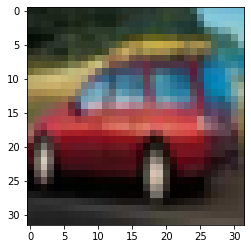

In [ ]:
#Plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)
#32x32 RGB
print("Conv input shape:", np.shape(my_image))

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

conv_output = Conv2d(my_image)
print("Filter weights:", filter_weights)
print("Conv output:", conv_output)
print("Conv output shape:", np.shape(Conv2d(my_image)))

Conv input shape: (1, 3, 32, 32)
Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0.27218536  0.27674967
   

In [ ]:
print('The filter weights passed to <my_conv_net> is:\n', filter_weights[0][0])
print('The shape is:', np.shape(filter_weights[0][0]))

The filter weights passed to <my_conv_net> is:
 [[ 0.7304995   0.6803058 ]
 [-1.0113425  -0.19040492]
 [-0.3848219   0.6740011 ]]
The shape is: (3, 2)


**In the cells below, we will create our own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that our convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. Draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [ ]:
def my_conv_net(my_image, initial_filter_weights):
    C_in, C_out = np.shape(initial_filter_weights)
    N, C_in, H, W = np.shape(my_image)
    my_conv_output = np.zeros((N, C_out, H, W))
    for c in range(C_out):
        for h in range(H):
            for w in range(W):
                #bias is ignored!
                for t in range(C_in):
                    my_conv_output[0, c, h, w] += my_image[0, t, h, w] * initial_filter_weights[t, c]

    return my_conv_output

In [ ]:
my_conv_output = my_conv_net(my_image, filter_weights[0][0])
print("My conv output:", my_conv_output)
print("objax conv output:", conv_output)

My conv output: [[[[-0.10271907 -0.10010862 -0.09076816 ... -0.7420423  -0.73912489
    -0.73746228]
   [-0.12882358 -0.11180527 -0.11687266 ... -0.73105443 -0.74346107
    -0.74085063]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.69911373 -0.71740329
    -0.71560836]
   ...
   [-0.11485984 -0.10963892 -0.10963892 ... -0.11178758 -0.11439803
    -0.12222938]
   [-0.09658667 -0.09136577 -0.09136577 ... -0.12745032 -0.12483985
    -0.12483985]
   [-0.08614486 -0.08353443 -0.08614486 ... -0.16399662 -0.16138616
    -0.15355483]]

  [[ 0.10279882  0.09823449  0.08189839 ...  0.75253248  0.7320599
     0.72146261]
   [ 0.14844204  0.12636711  0.1275416  ...  0.7793448   0.76264036
     0.75807607]
   [ 0.15300636  0.12562042  0.15036322 ...  0.7925384   0.7784524
     0.77533197]
   ...
   [ 0.20083013  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.15975127  0.15975127 ...  0.29957128  0.29500696
     0.29500696]
   [ 0.15062262  0.14605829  0.1506

In [ ]:
N, C_out, H, W = np.shape(my_conv_output)
class Getoutofloop(Exception):
    pass
try:
    for c in range(C_out):
        for h in range(H):
            for w in range(W):
                if np.abs(my_conv_output[0,c,h,w]-conv_output[0,c,h,w]) >= 0.0001:
                    raise Getoutofloop()
except Getoutofloop:
    print('\nThe outputs are not not 100% the same!')
    pass

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [ ]:
#Check that .mean((2,3)) rearranges your image
linear_input = my_conv_output.mean((2,3))
print("The rearranged conv output is:", linear_input)

The rearranged conv output is: [[-0.1400071   0.35388903]]


Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [ ]:
#RUN OBJAX LINEAR LAYER FIRST
linear_input_length = np.shape(linear_input)[1]
print("The length of linear input is:", linear_input_length)
Linear_Layer = objax.nn.Linear(linear_input_length, 1)
linear_output = Linear_Layer(linear_input)
print("Objax linear output is:", linear_output)

linear_weight = Linear_Layer.w.value
linear_bias = Linear_Layer.b.value
print("The weights of Objax linear layer are:\n", linear_weight)
print("The bias of Objax linear layer is:", linear_bias)

The length of linear input is: 2
Objax linear output is: [[0.03471544]]
The weights of Objax linear layer are:
 [[0.74953187]
 [0.39463   ]]
The bias of Objax linear layer is: [0.]


In [ ]:
#PUT YOUR CODE HERE
#A silly way of doing it:
# my_linear_output = linear_weight[0,0]*linear_input[0,0] + linear_weight[1,0]*linear_input[0,1] + linear_bias[0]
#One line of code for this question:
my_linear_output = linear_input.dot(linear_weight) + linear_bias[0]
print("My linear output is:", my_linear_output)

My linear output is: [[0.03471545]]


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement.

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [ ]:
#Define loss function as averaged value of of cross entropies
#labels=targets
#logit=output of the Base Model: CNN
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
#softmax(logit)
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
#x:data points, y:label?
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
        params.assign(params.value - lr*grad)                    
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train.shape[0], BATCH):
            if it+BATCH > X_train.shape[0]: #In case the size of training set is not divisible by BATCH
                BATCH = X_train.shape[0]-it
            batch = train_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            if it+BATCH > X_valid.shape[0]: #In case the size of validation set is not divisible by BATCH
                BATCH = X_valid.shape[0]-it
            batch = val_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.03
Epoch 0002  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.93 Validation Accuracy 10.37
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.65 Validation Accuracy 11.20
Epoch 0004  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.45 Validation Accuracy 11.77
Epoch 0005  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 12.12 Validation Accuracy 13.05
Epoch 0006  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.97 Validation Accuracy 13.12
Epoch 0007  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 13.34 Validation Accuracy 13.67
Epoch 0008  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 14.01 Validation Accuracy 15.28
Epoch 0009  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 15.29 Validation Accuracy 17.05
Epoch 0010  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 16.88 Validati

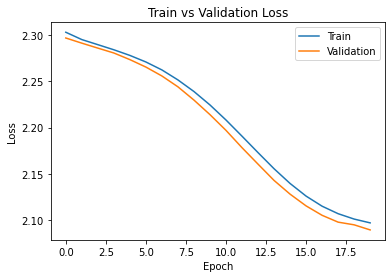

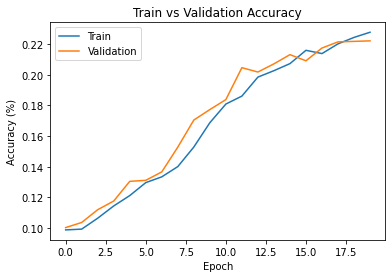

In [ ]:
train()

In [ ]:
# M1 AND TRAINING

In [ ]:
class ConvNet1(objax.Module):
    def __init__(self, number_of_channels = 3, number_of_classes = 10):
        self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
        self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
        self.linear = objax.nn.Linear(32, number_of_classes)

    def __call__(self, x):
        x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
        x = self.conv_2(x)

        x = x.mean((2,3)) #<--- global average pooling 
        x = self.linear(x)
        return x

#The following line creates the CNN
model1 = ConvNet1()

In [ ]:
#Define loss function as averaged value of of cross entropies
#labels=targets
#logit=output of the Base Model: CNN
def loss_function1(x, labels):
    logit = model1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
#softmax(logit)
predict1 = objax.Jit(lambda x: objax.functional.softmax(model1(x)), model1.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv1= objax.GradValues(loss_function1, model1.vars())

#Create an object that can be used to provide trainable variables in the model
tv1 = objax.ModuleList(objax.TrainRef(x) for x in model1.vars().subset(objax.TrainVar))

#Training routine
#x:data points, y:label?
def train_op1(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv1(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv1.vars()):
        params.assign(params.value - lr*grad)                  
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op1 = objax.Jit(train_op1, gv1.vars() + tv1.vars())

In [ ]:
def train1(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train.shape[0], BATCH):
            if it+BATCH > X_train.shape[0]: #In case the size of training set is not divisible by BATCH
                BATCH = X_train.shape[0]-it
            batch = train_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_train_loss += float(train_op1(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict1(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            if it+BATCH > X_valid.shape[0]: #In case the size of validation set is not divisible by BATCH
                BATCH = X_valid.shape[0]-it
            batch = val_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_val_loss += float(loss_function1(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict1(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.99 Validation Accuracy 16.58
Epoch 0002  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 15.80 Validation Accuracy 14.78
Epoch 0003  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 14.63 Validation Accuracy 15.02
Epoch 0004  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 16.21 Validation Accuracy 17.92
Epoch 0005  Training Loss 2.25 Validation Loss 2.23 Training Accuracy 18.17 Validation Accuracy 18.05
Epoch 0006  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 18.73 Validation Accuracy 19.25
Epoch 0007  Training Loss 2.20 Validation Loss 2.18 Training Accuracy 19.28 Validation Accuracy 19.28
Epoch 0008  Training Loss 2.17 Validation Loss 2.15 Training Accuracy 19.74 Validation Accuracy 19.52
Epoch 0009  Training Loss 2.15 Validation Loss 2.13 Training Accuracy 20.19 Validation Accuracy 19.52
Epoch 0010  Training Loss 2.13 Validation Loss 2.12 Training Accuracy 20.47 Valida

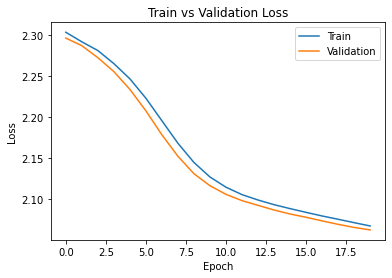

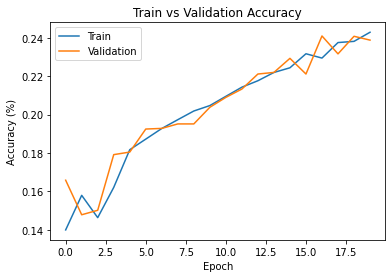

In [ ]:
train1()

In [ ]:
# M2 AND TRAINING

In [ ]:
class ConvNet2(objax.Module):
    def __init__(self, number_of_channels = 3, number_of_classes = 10):
        self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
        self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 16, 2), objax.functional.relu])
        self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
        self.linear = objax.nn.Linear(32, number_of_classes)

    def __call__(self, x):
        x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
        x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
        x = self.conv_3(x)

        x = x.mean((2,3)) #<--- global average pooling 
        x = self.linear(x)
        return x

#The following line creates the CNN
model2 = ConvNet2()

In [ ]:
#Define loss function as averaged value of of cross entropies
#labels=targets
#logit=output of the Base Model: CNN
def loss_function2(x, labels):
    logit = model2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
#softmax(logit)
predict2 = objax.Jit(lambda x: objax.functional.softmax(model2(x)), model2.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv2= objax.GradValues(loss_function2, model2.vars())

#Create an object that can be used to provide trainable variables in the model
tv2 = objax.ModuleList(objax.TrainRef(x) for x in model2.vars().subset(objax.TrainVar))

#Training routine
#x:data points, y:label?
def train_op2(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv2(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv2.vars()):
        params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op2 = objax.Jit(train_op2, gv2.vars() + tv2.vars())

In [ ]:
def train2(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    for epoch in range(EPOCHS):
    avg_train_loss = 0 # (averaged) training loss per batch
    avg_val_loss =  0  # (averaged) validation loss per batch
    train_acc = 0      # training accuracy per batch
    val_acc = 0        # validation accuracy per batch

    # shuffle the examples prior to training to remove correlation 
    train_indices = np.arange(len(X_train)) 
    np.random.shuffle(train_indices)
    for it in range(0, X_train.shape[0], BATCH):
        if it+BATCH > X_train.shape[0]: #In case the size of training set is not divisible by BATCH
            BATCH = X_train.shape[0]-it
        batch = train_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
        avg_train_loss += float(train_op2(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
        train_prediction = predict2(X_train[batch]).argmax(1)
        train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
    train_acc_epoch.append(train_acc/X_train.shape[0])
    avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

    # run validation
    val_indices = np.arange(len(X_valid)) 
    np.random.shuffle(val_indices)    
    for it in range(0, X_valid.shape[0], BATCH):
        if it+BATCH > X_valid.shape[0]: #In case the size of validation set is not divisible by BATCH
            BATCH = X_valid.shape[0]-it
        batch = val_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
        avg_val_loss += float(loss_function2(X_valid[batch], Y_valid[batch])) * len(batch)
        val_prediction = predict2(X_valid[batch]).argmax(1)
        val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
    val_acc_epoch.append(val_acc/X_valid.shape[0])
    avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

    print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 10.82 Validation Accuracy 11.58
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.88 Validation Accuracy 12.88
Epoch 0003  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 14.03 Validation Accuracy 14.10
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 16.22 Validation Accuracy 17.85
Epoch 0005  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 17.85 Validation Accuracy 17.77
Epoch 0006  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 17.74 Validation Accuracy 18.33
Epoch 0007  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 18.83 Validation Accuracy 18.92
Epoch 0008  Training Loss 2.23 Validation Loss 2.20 Training Accuracy 19.28 Validation Accuracy 19.63
Epoch 0009  Training Loss 2.18 Validation Loss 2.16 Training Accuracy 20.33 Validation Accuracy 19.92
Epoch 0010  Training Loss 2.15 Validation Loss 2.13 Training Accuracy 21.04 Valida

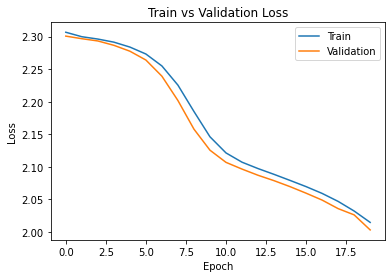

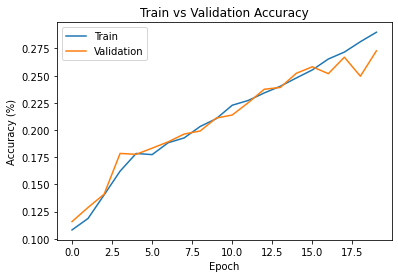

In [ ]:
train2()

In [ ]:
# M3 AND TRAINING
# M1 increases the number of outputs of conv layer 1 from 16 to 32 and get a slight improvement
# M2 increases the number of conv layers from 2 to 3 and get a medium improvement
# M3 simply combines M1 and M2 together

In [ ]:
class ConvNet3(objax.Module):
    def __init__(self, number_of_channels = 3, number_of_classes = 10):
        self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
        self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
        self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
        self.linear = objax.nn.Linear(32, number_of_classes)

    def __call__(self, x):
        x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
        x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
        x = self.conv_3(x)

        x = x.mean((2,3)) #<--- global average pooling 
        x = self.linear(x)
        return x

#The following line creates the CNN
model3 = ConvNet3()

In [ ]:
#Define loss function as averaged value of of cross entropies
#labels=targets
#logit=output of the Base Model: CNN
def loss_function3(x, labels):
    logit = model3(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
#softmax(logit)
predict3 = objax.Jit(lambda x: objax.functional.softmax(model3(x)), model3.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv3= objax.GradValues(loss_function3, model3.vars())

#Create an object that can be used to provide trainable variables in the model
tv3 = objax.ModuleList(objax.TrainRef(x) for x in model3.vars().subset(objax.TrainVar))

#Training routine
#x:data points, y:label?
def train_op3(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv3(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv3.vars()):
        params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op3 = objax.Jit(train_op3, gv3.vars() + tv3.vars())

In [ ]:
def train3(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train.shape[0], BATCH):
            if it+BATCH > X_train.shape[0]: #In case the size of training set is not divisible by BATCH
                BATCH = X_train.shape[0]-it
            batch = train_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_train_loss += float(train_op3(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict3(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            if it+BATCH > X_valid.shape[0]: #In case the size of validation set is not divisible by BATCH
                BATCH = X_valid.shape[0]-it
            batch = val_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_val_loss += float(loss_function3(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict3(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 10.04 Validation Accuracy 9.63
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 11.71 Validation Accuracy 13.68
Epoch 0003  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 16.04 Validation Accuracy 16.47
Epoch 0004  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 16.00 Validation Accuracy 16.68
Epoch 0005  Training Loss 2.25 Validation Loss 2.23 Training Accuracy 16.39 Validation Accuracy 14.77
Epoch 0006  Training Loss 2.21 Validation Loss 2.19 Training Accuracy 16.30 Validation Accuracy 17.25
Epoch 0007  Training Loss 2.16 Validation Loss 2.14 Training Accuracy 19.49 Validation Accuracy 20.48
Epoch 0008  Training Loss 2.12 Validation Loss 2.11 Training Accuracy 22.15 Validation Accuracy 22.77
Epoch 0009  Training Loss 2.10 Validation Loss 2.09 Training Accuracy 23.48 Validation Accuracy 22.65
Epoch 0010  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 24.15 Validat

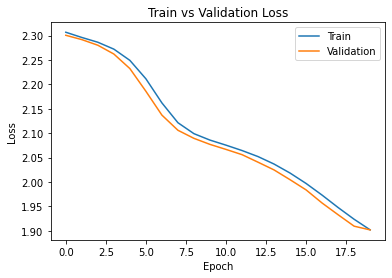

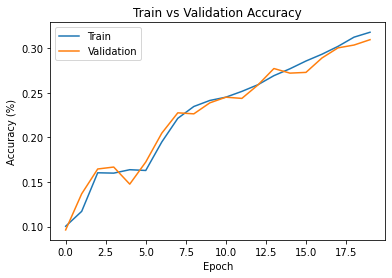

In [ ]:
train3()
#It seems that M1+M2 is indeed better than either M1 or M2 alone.

In [ ]:
test_acc = 0
avg_test_loss = 0
BATCH = 32
# run test
test_indices = np.arange(len(X_test)) 
np.random.shuffle(test_indices)    
for it in range(0, X_test.shape[0], BATCH):
    if it+BATCH > X_test.shape[0]: #In case the size of validation set is not divisible by BATCH
        BATCH = X_test.shape[0]-it
    batch = test_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
    avg_test_loss += float(loss_function3(X_test[batch], Y_test[batch])) * len(batch)
    test_prediction = predict3(X_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()

print('Test Loss %.2f Test Accuracy %.2f ' % (avg_test_loss/X_test.shape[0], 100*test_acc/X_test.shape[0]))
  

Test Loss 1.91 Test Accuracy 29.82 


##**Part 3. Trying Out a New Dataset**

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
ds = tfds.load('eurosat')
print('The number of data points is:', len(ds['train']))
arr = np.vstack(tfds.as_numpy(ds['train']))
print('The length of the arr is:', len(arr))

The number of data points is: 27000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


The length of the arr is: 27000


In [ ]:
XY = np.array(list(map(lambda x: x[0], arr)))
X_data = np.array([XY[i]['image'] for i in range(len(arr))])
Y_data = np.array([XY[i]['label'] for i in range(len(arr))])

print('The length of the entire dataset is:,', len(X_data))
N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Very important to transpose the X_data
print("The shape of the training data is:", np.shape(X_data))
X_data = X_data.transpose((0,3,1,2))/255.0
print("The shape of the transposed training data is:", np.shape(X_data))

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]
print('The length of X_train is:,', len(X_train))
print('The length of X_valid is:,', len(X_valid))
print('The length of X_test is:,', len(X_test))

The length of the entire dataset is:, 27000
The shape of the training data is: (27000, 64, 64, 3)
The shape of the transposed training data is: (27000, 3, 64, 64)
The length of X_train is:, 21600
The length of X_valid is:, 2700
The length of X_test is:, 2700


In [ ]:
print("The shape of the training data is:", np.shape(X_train))
print("The shape of the training labels is:", np.shape(Y_train))

The shape of the training data is: (21600, 3, 64, 64)
The shape of the training labels is: (21600,)


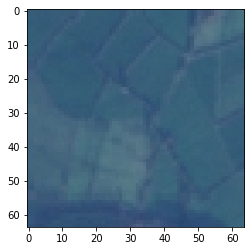

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

In [ ]:
class ConvNet30(objax.Module):
    def __init__(self, number_of_channels = 3, number_of_classes = 10):
        self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
        self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
        self.linear = objax.nn.Linear(32, number_of_classes)

    def __call__(self, x):
        x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
        x = self.conv_2(x)

        x = x.mean((2,3)) #<--- global average pooling 
        x = self.linear(x)
        return x

#The following line creates the CNN
model30 = ConvNet30()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
#labels=targets
#logit=output of the Base Model: CNN
def loss_function30(x, labels):
    logit = model30(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
#softmax(logit)
predict30 = objax.Jit(lambda x: objax.functional.softmax(model30(x)), model30.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv30 = objax.GradValues(loss_function30, model30.vars())

#Create an object that can be used to provide trainable variables in the model
tv30 = objax.ModuleList(objax.TrainRef(x) for x in model30.vars().subset(objax.TrainVar))

#Training routine
#x:data points, y:label?
def train_op30(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv30(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv30.vars()):
        params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op30 = objax.Jit(train_op30, gv30.vars() + tv30.vars())

In [ ]:
def train30(EPOCHS = 20, BATCH = 30, LEARNING_RATE = 9e-4):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train.shape[0], BATCH):
            if it+BATCH > X_train.shape[0]: #In case the size of training set is not divisible by BATCH
                BATCH = X_train.shape[0]-it
            batch = train_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_train_loss += float(train_op30(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict30(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            if it+BATCH > X_valid.shape[0]: #In case the size of validation set is not divisible by BATCH
                BATCH = X_valid.shape[0]-it
            batch = val_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_val_loss += float(loss_function30(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict30(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

Epoch 0001  Training Loss 2.28 Validation Loss 2.25 Training Accuracy 10.79 Validation Accuracy 13.48
Epoch 0002  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 10.94 Validation Accuracy 10.41
Epoch 0003  Training Loss 2.23 Validation Loss 2.22 Training Accuracy 10.75 Validation Accuracy 10.56
Epoch 0004  Training Loss 2.21 Validation Loss 2.20 Training Accuracy 13.00 Validation Accuracy 14.70
Epoch 0005  Training Loss 2.20 Validation Loss 2.19 Training Accuracy 16.82 Validation Accuracy 18.67
Epoch 0006  Training Loss 2.18 Validation Loss 2.17 Training Accuracy 19.41 Validation Accuracy 20.48
Epoch 0007  Training Loss 2.16 Validation Loss 2.15 Training Accuracy 20.87 Validation Accuracy 21.41
Epoch 0008  Training Loss 2.14 Validation Loss 2.13 Training Accuracy 21.56 Validation Accuracy 21.78
Epoch 0009  Training Loss 2.12 Validation Loss 2.11 Training Accuracy 21.89 Validation Accuracy 21.96
Epoch 0010  Training Loss 2.10 Validation Loss 2.09 Training Accuracy 22.22 Valida

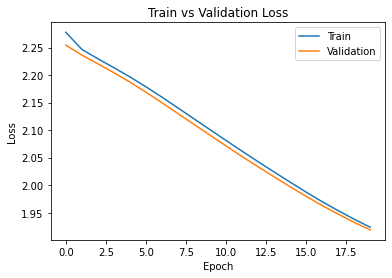

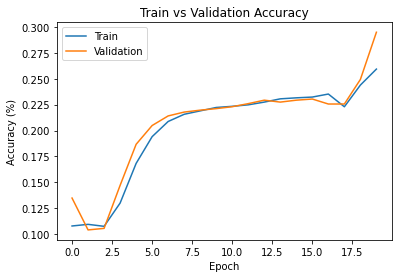

In [ ]:
train30()

In [ ]:
# TUNE HYPERPARAMETERS
# 1. number of conv layers
# 2. number of outputs of conv layers

In [ ]:
class ConvNet31(objax.Module):
    def __init__(self, number_of_channels = 3, number_of_classes = 10):
        self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
        self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.functional.relu])
        self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(64, 32, 2), objax.functional.relu])
        self.linear = objax.nn.Linear(32, number_of_classes)

    def __call__(self, x):
        x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
        x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
        x = self.conv_3(x)

        x = x.mean((2,3)) #<--- global average pooling 
        x = self.linear(x)
        return x

#The following line creates the CNN
model31 = ConvNet31()

In [ ]:
#Define loss function as averaged value of of cross entropies
#labels=targets
#logit=output of the Base Model: CNN
def loss_function31(x, labels):
    logit = model31(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
#softmax(logit)
predict31 = objax.Jit(lambda x: objax.functional.softmax(model31(x)), model31.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv31 = objax.GradValues(loss_function31, model31.vars())

#Create an object that can be used to provide trainable variables in the model
tv31 = objax.ModuleList(objax.TrainRef(x) for x in model31.vars().subset(objax.TrainVar))

#Training routine
#x:data points, y:label?
def train_op31(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv31(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv31.vars()):
        params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op31 = objax.Jit(train_op31, gv31.vars() + tv31.vars())

In [ ]:
def train31(EPOCHS = 20, BATCH = 30, LEARNING_RATE = 9e-4):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train.shape[0], BATCH):
            if it+BATCH > X_train.shape[0]: #In case the size of training set is not divisible by BATCH
                BATCH = X_train.shape[0]-it
            batch = train_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_train_loss += float(train_op31(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict31(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            if it+BATCH > X_valid.shape[0]: #In case the size of validation set is not divisible by BATCH
                BATCH = X_valid.shape[0]-it
            batch = val_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_val_loss += float(loss_function31(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict31(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

Epoch 0001  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 9.48 Validation Accuracy 11.07
Epoch 0002  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 12.61 Validation Accuracy 15.22
Epoch 0003  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 17.26 Validation Accuracy 13.78
Epoch 0004  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 18.91 Validation Accuracy 23.37
Epoch 0005  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 23.68 Validation Accuracy 27.07
Epoch 0006  Training Loss 2.20 Validation Loss 2.19 Training Accuracy 26.36 Validation Accuracy 28.52
Epoch 0007  Training Loss 2.18 Validation Loss 2.16 Training Accuracy 28.65 Validation Accuracy 30.59
Epoch 0008  Training Loss 2.15 Validation Loss 2.14 Training Accuracy 30.15 Validation Accuracy 31.63
Epoch 0009  Training Loss 2.12 Validation Loss 2.10 Training Accuracy 30.10 Validation Accuracy 31.48
Epoch 0010  Training Loss 2.08 Validation Loss 2.06 Training Accuracy 31.13 Validat

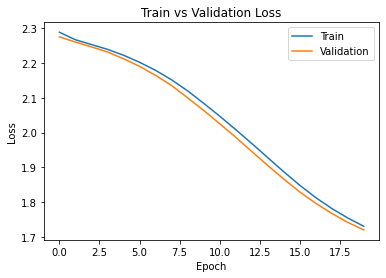

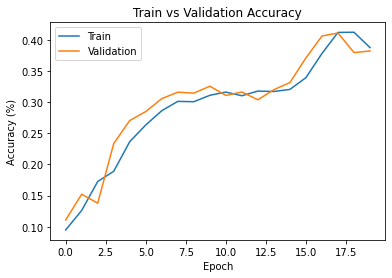

In [ ]:
train31()

In [ ]:
test_acc = 0
avg_test_loss = 0
BATCH = 30
# run test
test_indices = np.arange(len(X_test)) 
np.random.shuffle(test_indices)    
for it in range(0, X_test.shape[0], BATCH):
    if it+BATCH > X_test.shape[0]: #In case the size of validation set is not divisible by BATCH
        BATCH = X_test.shape[0]-it
    batch = test_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
    avg_test_loss += float(loss_function31(X_test[batch], Y_test[batch])) * len(batch)
    test_prediction = predict31(X_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()

print('Test Loss %.2f Test Accuracy %.2f ' % (avg_test_loss/X_test.shape[0], 100*test_acc/X_test.shape[0]))

Test Loss 1.72 Test Accuracy 38.52 


##**Problem 4. Open-Ended Exploration**

In [ ]:
# Problem 4
# 1. Additional hyperparameter tuning
# Increase:
# the number of outputs of the first conv layer
# the number of conv layers
# the learning rate from 9e-4 to 5e-2
# achieve 84% validation accuracy and test accuracy

In [ ]:
class ConvNet49(objax.Module):
    def __init__(self, number_of_channels = 3, number_of_classes = 10):
        self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
        self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
        self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.functional.relu])
        self.conv_4 = objax.nn.Sequential([objax.nn.Conv2D(64, 128, 2), objax.functional.relu])
        self.conv_5 = objax.nn.Sequential([objax.nn.Conv2D(128, 32, 2), objax.functional.relu])
        self.linear = objax.nn.Linear(32, number_of_classes)

    def __call__(self, x):
        x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
        x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
        x = objax.functional.max_pool_2d(self.conv_3(x), 2, 2)
        x = objax.functional.max_pool_2d(self.conv_4(x), 2, 2)
        x = self.conv_5(x)

        x = x.mean((2,3)) #<--- global average pooling 
        x = self.linear(x)
        return x

#The following line creates the CNN
model49 = ConvNet49()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
#labels=targets
#logit=output of the Base Model: CNN
def loss_function49(x, labels):
    logit = model49(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
#softmax(logit)
predict49 = objax.Jit(lambda x: objax.functional.softmax(model49(x)), model49.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv49 = objax.GradValues(loss_function49, model49.vars())

#Create an object that can be used to provide trainable variables in the model
tv49 = objax.ModuleList(objax.TrainRef(x) for x in model49.vars().subset(objax.TrainVar))

#Training routine
#x:data points, y:label?
def train_op49(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv49(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv49.vars()):
        params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op49 = objax.Jit(train_op49, gv49.vars() + tv49.vars())

In [ ]:
def train49(EPOCHS = 20, BATCH = 30, LEARNING_RATE = 5e-2):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train.shape[0], BATCH):
            if it+BATCH > X_train.shape[0]: #In case the size of training set is not divisible by BATCH
                BATCH = X_train.shape[0]-it
            batch = train_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_train_loss += float(train_op49(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict49(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            if it+BATCH > X_valid.shape[0]: #In case the size of validation set is not divisible by BATCH
                BATCH = X_valid.shape[0]-it
            batch = val_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_val_loss += float(loss_function49(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict49(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

Epoch 0001  Training Loss 1.84 Validation Loss 1.61 Training Accuracy 34.82 Validation Accuracy 35.56
Epoch 0002  Training Loss 1.42 Validation Loss 1.16 Training Accuracy 54.04 Validation Accuracy 60.44
Epoch 0003  Training Loss 1.16 Validation Loss 1.41 Training Accuracy 65.45 Validation Accuracy 47.93
Epoch 0004  Training Loss 0.98 Validation Loss 1.00 Training Accuracy 72.29 Validation Accuracy 61.70
Epoch 0005  Training Loss 0.86 Validation Loss 0.71 Training Accuracy 76.85 Validation Accuracy 74.93
Epoch 0006  Training Loss 0.78 Validation Loss 0.66 Training Accuracy 79.90 Validation Accuracy 75.74
Epoch 0007  Training Loss 0.71 Validation Loss 0.84 Training Accuracy 82.78 Validation Accuracy 67.85
Epoch 0008  Training Loss 0.66 Validation Loss 0.58 Training Accuracy 84.94 Validation Accuracy 79.11
Epoch 0009  Training Loss 0.61 Validation Loss 0.73 Training Accuracy 86.85 Validation Accuracy 73.48
Epoch 0010  Training Loss 0.56 Validation Loss 0.55 Training Accuracy 88.75 Valida

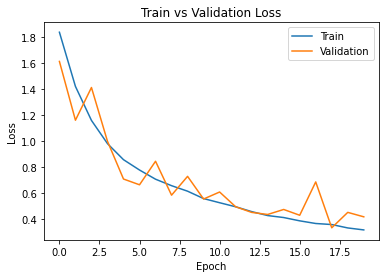

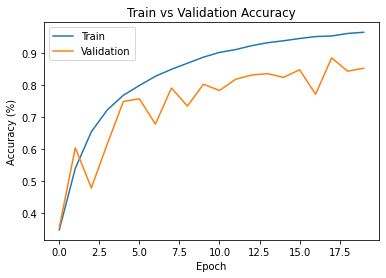

In [ ]:
train49()

In [ ]:
test_acc = 0
avg_test_loss = 0
BATCH = 30
# run test
test_indices = np.arange(len(X_test)) 
np.random.shuffle(test_indices)    
for it in range(0, X_test.shape[0], BATCH):
    if it+BATCH > X_test.shape[0]: #In case the size of validation set is not divisible by BATCH
        BATCH = X_test.shape[0]-it
    batch = test_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
    avg_test_loss += float(loss_function49(X_test[batch], Y_test[batch])) * len(batch)
    test_prediction = predict49(X_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()

print('Test Loss %.2f Test Accuracy %.2f ' % (avg_test_loss/X_test.shape[0], 100*test_acc/X_test.shape[0]))

Test Loss 0.38 Test Accuracy 86.59 


In [ ]:
# 2. How do hyperparameters interact ? 

# Two hyperparameters that can independently increases the performance each, 
# and also increase the performance when used together

In [ ]:
# Only increase the learning rate from 9e-4 to 9e-3

In [ ]:
class ConvNet41(objax.Module):
    def __init__(self, number_of_channels = 3, number_of_classes = 10):
        self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
        self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
        self.linear = objax.nn.Linear(32, number_of_classes)

    def __call__(self, x):
        x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
        x = self.conv_2(x)

        x = x.mean((2,3)) #<--- global average pooling 
        x = self.linear(x)
        return x

#The following line creates the CNN
model41 = ConvNet41()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
#labels=targets
#logit=output of the Base Model: CNN
def loss_function41(x, labels):
    logit = model41(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
#softmax(logit)
predict41 = objax.Jit(lambda x: objax.functional.softmax(model41(x)), model41.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv41 = objax.GradValues(loss_function41, model41.vars())

#Create an object that can be used to provide trainable variables in the model
tv41 = objax.ModuleList(objax.TrainRef(x) for x in model41.vars().subset(objax.TrainVar))

#Training routine
#x:data points, y:label?
def train_op41(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv41(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv41.vars()):
        params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op41 = objax.Jit(train_op41, gv41.vars() + tv41.vars())

In [ ]:
def train41(EPOCHS = 20, BATCH = 30, LEARNING_RATE = 9e-3):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train.shape[0], BATCH):
            if it+BATCH > X_train.shape[0]: #In case the size of training set is not divisible by BATCH
                BATCH = X_train.shape[0]-it
            batch = train_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_train_loss += float(train_op41(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict41(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            if it+BATCH > X_valid.shape[0]: #In case the size of validation set is not divisible by BATCH
                BATCH = X_valid.shape[0]-it
            batch = val_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_val_loss += float(loss_function41(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict41(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

Epoch 0001  Training Loss 2.21 Validation Loss 2.13 Training Accuracy 19.38 Validation Accuracy 31.93
Epoch 0002  Training Loss 2.05 Validation Loss 1.97 Training Accuracy 30.77 Validation Accuracy 28.22
Epoch 0003  Training Loss 1.90 Validation Loss 1.85 Training Accuracy 30.34 Validation Accuracy 28.59
Epoch 0004  Training Loss 1.81 Validation Loss 1.79 Training Accuracy 33.13 Validation Accuracy 34.93
Epoch 0005  Training Loss 1.76 Validation Loss 1.75 Training Accuracy 35.35 Validation Accuracy 36.22
Epoch 0006  Training Loss 1.73 Validation Loss 1.72 Training Accuracy 37.38 Validation Accuracy 34.89
Epoch 0007  Training Loss 1.69 Validation Loss 1.69 Training Accuracy 38.81 Validation Accuracy 34.89
Epoch 0008  Training Loss 1.65 Validation Loss 1.63 Training Accuracy 40.83 Validation Accuracy 40.37
Epoch 0009  Training Loss 1.60 Validation Loss 1.59 Training Accuracy 42.64 Validation Accuracy 42.00
Epoch 0010  Training Loss 1.56 Validation Loss 1.55 Training Accuracy 44.51 Valida

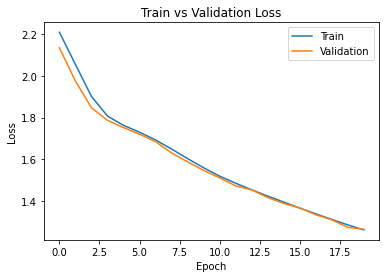

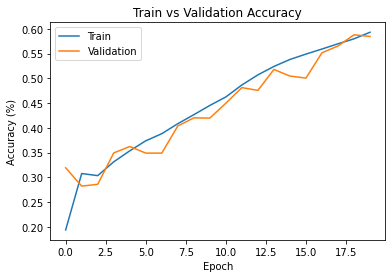

In [ ]:
train41()

In [ ]:
# Only increase the number of conv layers from 2 to 3

In [ ]:
class ConvNet42(objax.Module):
    def __init__(self, number_of_channels = 3, number_of_classes = 10):
        self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
        self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
        self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
        self.linear = objax.nn.Linear(32, number_of_classes)

    def __call__(self, x):
        x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
        x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
        x = self.conv_3(x)

        x = x.mean((2,3)) #<--- global average pooling 
        x = self.linear(x)
        return x

#The following line creates the CNN
model42 = ConvNet42()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
#labels=targets
#logit=output of the Base Model: CNN
def loss_function42(x, labels):
    logit = model42(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
#softmax(logit)
predict42 = objax.Jit(lambda x: objax.functional.softmax(model42(x)), model42.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv42 = objax.GradValues(loss_function42, model42.vars())

#Create an object that can be used to provide trainable variables in the model
tv42 = objax.ModuleList(objax.TrainRef(x) for x in model42.vars().subset(objax.TrainVar))

#Training routine
#x:data points, y:label?
def train_op42(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv42(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv42.vars()):
        params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op42 = objax.Jit(train_op42, gv42.vars() + tv42.vars())

In [ ]:
def train42(EPOCHS = 20, BATCH = 30, LEARNING_RATE = 9e-4):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train.shape[0], BATCH):
            if it+BATCH > X_train.shape[0]: #In case the size of training set is not divisible by BATCH
                BATCH = X_train.shape[0]-it
            batch = train_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_train_loss += float(train_op42(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict42(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            if it+BATCH > X_valid.shape[0]: #In case the size of validation set is not divisible by BATCH
                BATCH = X_valid.shape[0]-it
            batch = val_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_val_loss += float(loss_function42(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict42(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 8.95 Validation Accuracy 9.44
Epoch 0002  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.89 Validation Accuracy 14.96
Epoch 0003  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 17.61 Validation Accuracy 18.78
Epoch 0004  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 21.16 Validation Accuracy 24.41
Epoch 0005  Training Loss 2.23 Validation Loss 2.23 Training Accuracy 25.26 Validation Accuracy 26.04
Epoch 0006  Training Loss 2.21 Validation Loss 2.20 Training Accuracy 25.31 Validation Accuracy 25.07
Epoch 0007  Training Loss 2.19 Validation Loss 2.17 Training Accuracy 25.41 Validation Accuracy 22.59
Epoch 0008  Training Loss 2.16 Validation Loss 2.14 Training Accuracy 24.64 Validation Accuracy 26.07
Epoch 0009  Training Loss 2.11 Validation Loss 2.09 Training Accuracy 27.11 Validation Accuracy 29.48
Epoch 0010  Training Loss 2.07 Validation Loss 2.05 Training Accuracy 29.79 Validati

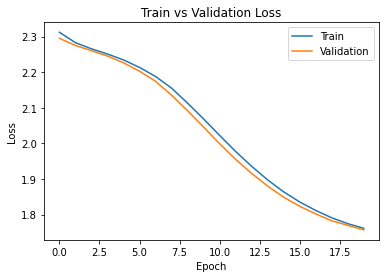

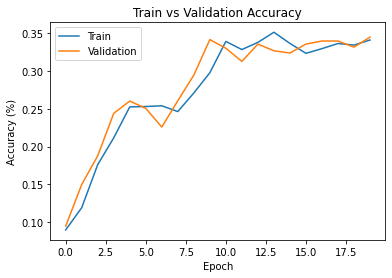

In [ ]:
train42()

In [ ]:
# COMBINE HYPERPARAMETERS
# 1. increase the learning rate from 9e-4 to 9e-3
# 2. increase the number of conv layers from 2 to 3

In [ ]:
class ConvNet43(objax.Module):
    def __init__(self, number_of_channels = 3, number_of_classes = 10):
        self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
        self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
        self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
        self.linear = objax.nn.Linear(32, number_of_classes)

    def __call__(self, x):
        x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
        x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
        x = self.conv_3(x)

        x = x.mean((2,3)) #<--- global average pooling 
        x = self.linear(x)
        return x

#The following line creates the CNN
model43 = ConvNet43()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
#labels=targets
#logit=output of the Base Model: CNN
def loss_function43(x, labels):
    logit = model43(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
#softmax(logit)
predict43 = objax.Jit(lambda x: objax.functional.softmax(model43(x)), model43.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv43 = objax.GradValues(loss_function43, model43.vars())

#Create an object that can be used to provide trainable variables in the model
tv43 = objax.ModuleList(objax.TrainRef(x) for x in model43.vars().subset(objax.TrainVar))

#Training routine
#x:data points, y:label?
def train_op43(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv43(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv43.vars()):
        params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op43 = objax.Jit(train_op43, gv43.vars() + tv43.vars())

In [ ]:
def train43(EPOCHS = 20, BATCH = 30, LEARNING_RATE = 9e-3):
    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    for epoch in range(EPOCHS):
        avg_train_loss = 0 # (averaged) training loss per batch
        avg_val_loss =  0  # (averaged) validation loss per batch
        train_acc = 0      # training accuracy per batch
        val_acc = 0        # validation accuracy per batch

        # shuffle the examples prior to training to remove correlation 
        train_indices = np.arange(len(X_train)) 
        np.random.shuffle(train_indices)
        for it in range(0, X_train.shape[0], BATCH):
            if it+BATCH > X_train.shape[0]: #In case the size of training set is not divisible by BATCH
                BATCH = X_train.shape[0]-it
            batch = train_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_train_loss += float(train_op43(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
            train_prediction = predict43(X_train[batch]).argmax(1)
            train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
        train_acc_epoch.append(train_acc/X_train.shape[0])
        avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

        # run validation
        val_indices = np.arange(len(X_valid)) 
        np.random.shuffle(val_indices)    
        for it in range(0, X_valid.shape[0], BATCH):
            if it+BATCH > X_valid.shape[0]: #In case the size of validation set is not divisible by BATCH
                BATCH = X_valid.shape[0]-it
            batch = val_indices[np.arange(it, it+BATCH)] #PUT YOUR CODE HERE#
            avg_val_loss += float(loss_function43(X_valid[batch], Y_valid[batch])) * len(batch)
            val_prediction = predict43(X_valid[batch]).argmax(1)
            val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
        val_acc_epoch.append(val_acc/X_valid.shape[0])
        avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

Epoch 0001  Training Loss 2.21 Validation Loss 2.09 Training Accuracy 19.44 Validation Accuracy 29.63
Epoch 0002  Training Loss 1.99 Validation Loss 1.90 Training Accuracy 26.60 Validation Accuracy 25.89
Epoch 0003  Training Loss 1.82 Validation Loss 1.77 Training Accuracy 31.13 Validation Accuracy 29.19
Epoch 0004  Training Loss 1.74 Validation Loss 1.72 Training Accuracy 35.55 Validation Accuracy 34.22
Epoch 0005  Training Loss 1.66 Validation Loss 1.60 Training Accuracy 39.66 Validation Accuracy 39.93
Epoch 0006  Training Loss 1.56 Validation Loss 1.51 Training Accuracy 43.02 Validation Accuracy 41.56
Epoch 0007  Training Loss 1.50 Validation Loss 1.62 Training Accuracy 46.02 Validation Accuracy 38.70
Epoch 0008  Training Loss 1.47 Validation Loss 1.52 Training Accuracy 49.15 Validation Accuracy 46.93
Epoch 0009  Training Loss 1.44 Validation Loss 1.41 Training Accuracy 52.10 Validation Accuracy 46.30
Epoch 0010  Training Loss 1.41 Validation Loss 1.41 Training Accuracy 53.15 Valida

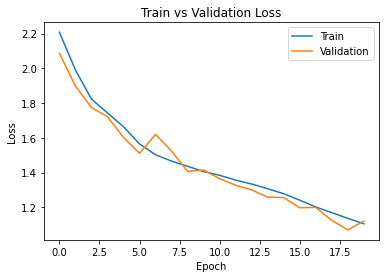

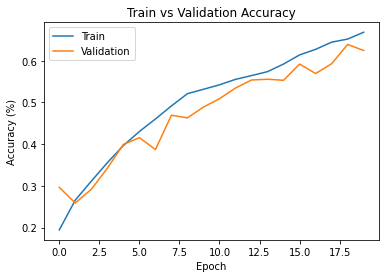

In [ ]:
train43()